<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [1]:
import matplotlib.pyplot as plt

% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston

boston = load_boston()

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])

print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

/Users/tanyongjin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California 

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [3]:
# Exploratory data analysis.

# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column

X.info()
# No missing values
# 506 rows X 13 columns, all of type 'float64'

X.describe()

X.head(10)
# CHAS and RAD could be more of categorical columns passed as float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10


In [4]:
X['CHAS'].unique()
# 0 or 1

X['RAD'].unique()
# 1,2,3,4,5,6,7,24
# value of 24 looks unnatural for the column when the initial values go from 1 to 7, it could be an outlier figure

X[X['RAD'] == 24]
# 132 rows extracted. Rows with RAD value of 24 are not outliers.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
356,8.98296,0.0,18.1,1.0,0.770,6.212,97.4,2.1222,24.0,666.0,20.2,377.73,17.60
357,3.84970,0.0,18.1,1.0,0.770,6.395,91.0,2.5052,24.0,666.0,20.2,391.34,13.27
358,5.20177,0.0,18.1,1.0,0.770,6.127,83.4,2.7227,24.0,666.0,20.2,395.43,11.48
359,4.26131,0.0,18.1,0.0,0.770,6.112,81.3,2.5091,24.0,666.0,20.2,390.74,12.67
360,4.54192,0.0,18.1,0.0,0.770,6.398,88.0,2.5182,24.0,666.0,20.2,374.56,7.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,2.81838,0.0,18.1,0.0,0.532,5.762,40.3,4.0983,24.0,666.0,20.2,392.92,10.42
484,2.37857,0.0,18.1,0.0,0.583,5.871,41.9,3.7240,24.0,666.0,20.2,370.73,13.34
485,3.67367,0.0,18.1,0.0,0.583,6.312,51.9,3.9917,24.0,666.0,20.2,388.62,10.58
486,5.69175,0.0,18.1,0.0,0.583,6.114,79.8,3.5459,24.0,666.0,20.2,392.68,14.98


## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

In [5]:
# Previously, I did a correlation matrix for each variable with the target variable.
# This time I would like to try picking 4 variables without any knowledge from the target column.

# Which means, I should try to pick 4 variables who have (ideally) 0 correlation with one another.

# Picking variables with high correlation with one another 
# only wastes the amount of variables I can work with
# since I am limiting myself to choose only 4 out of 13 available.


X.corr()
# A wall of numbers, not too obvious who to pick, unless I go through the rows one by one.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993


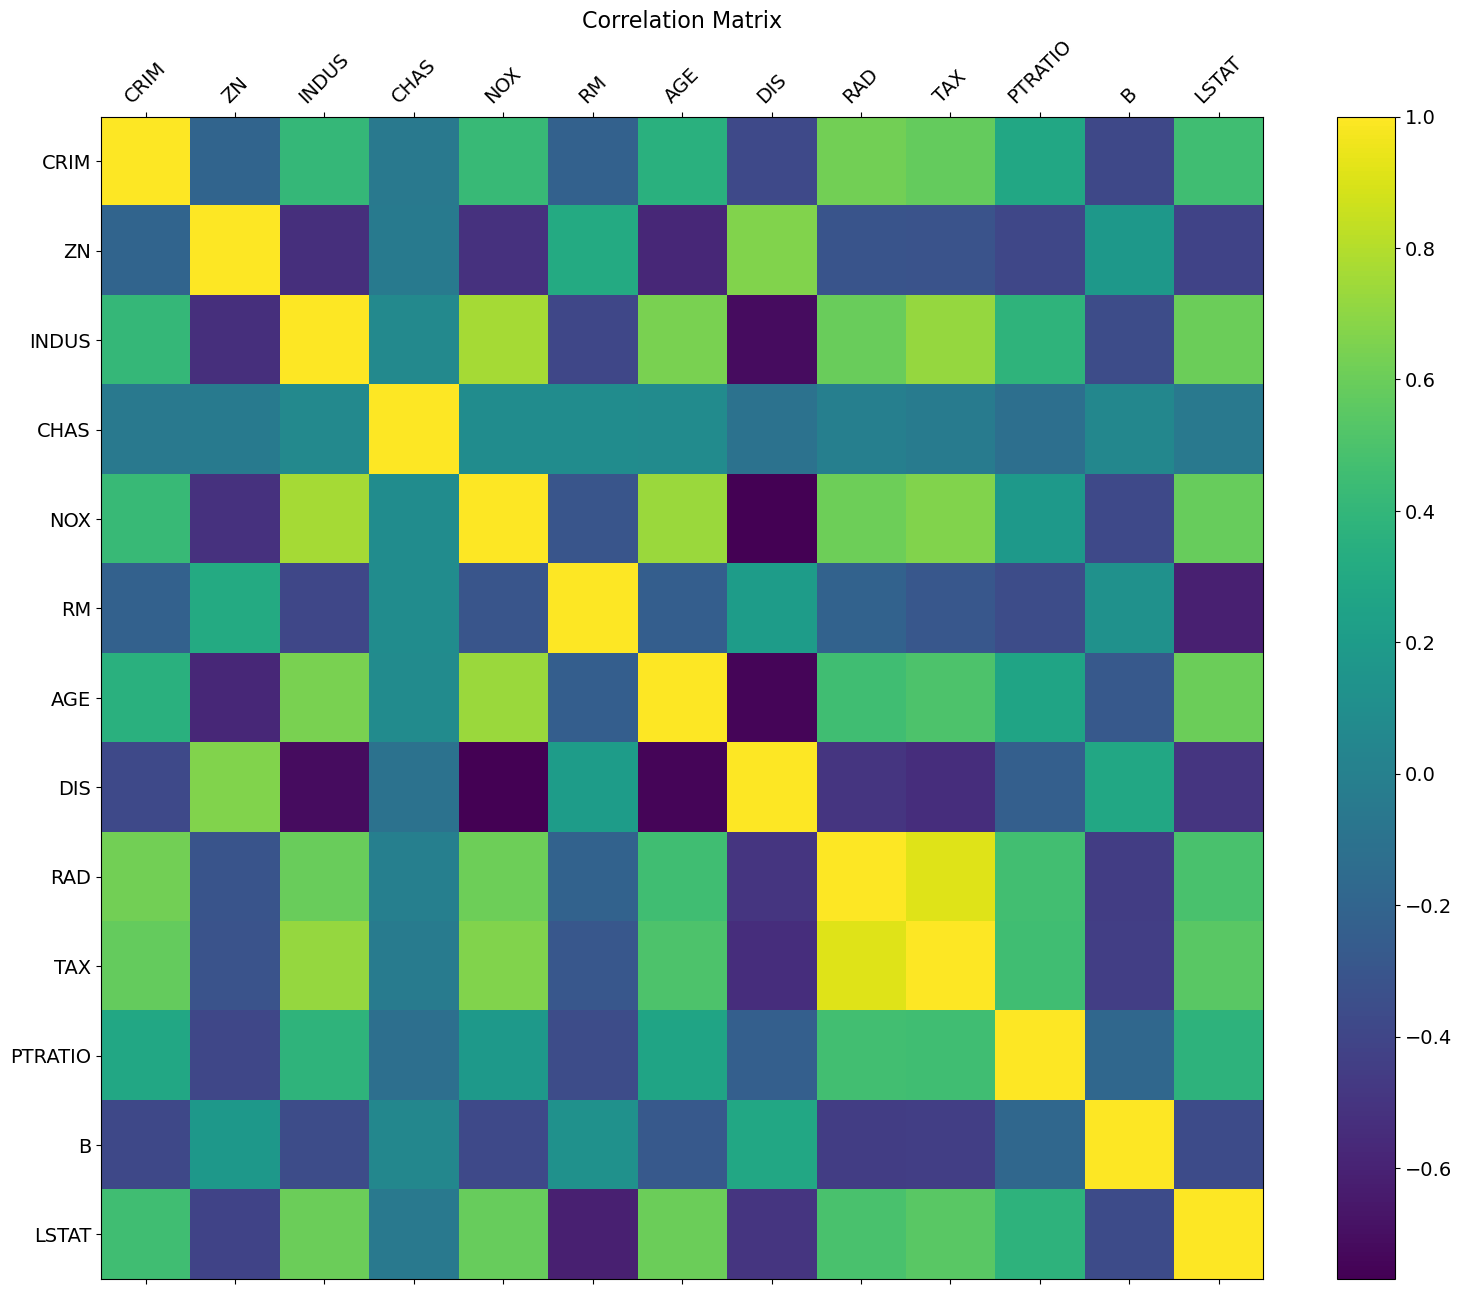

In [6]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(19, 15))
plt.matshow(X.corr(), fignum=f.number)
plt.xticks(range(X.select_dtypes(['number']).shape[1]), X.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(X.select_dtypes(['number']).shape[1]), X.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

# With graphical representation, it is still hard to discern the heatmap where the colours are hihgly similiar.

In [7]:
# Shall try to get the mean of the correlation matrix for each column in respective of all other columns
X.corr().mean()

CRIM       0.222599
ZN        -0.087877
INDUS      0.245414
CHAS       0.074195
NOX        0.238346
RM        -0.068309
AGE        0.216201
DIS       -0.177023
RAD        0.283352
TAX        0.290357
PTRATIO    0.164979
B         -0.090879
LSTAT      0.208888
dtype: float64

In [8]:
# ZN / CHAS / RM / B
# This 4 variable have a mean correlation close to 0, in respect to all other columns

features = ['ZN','CHAS','RM','B']

# Select these 4 features for training
X = X[features]

0.5353722259116198
0.6755346234622038
32.066066135200145


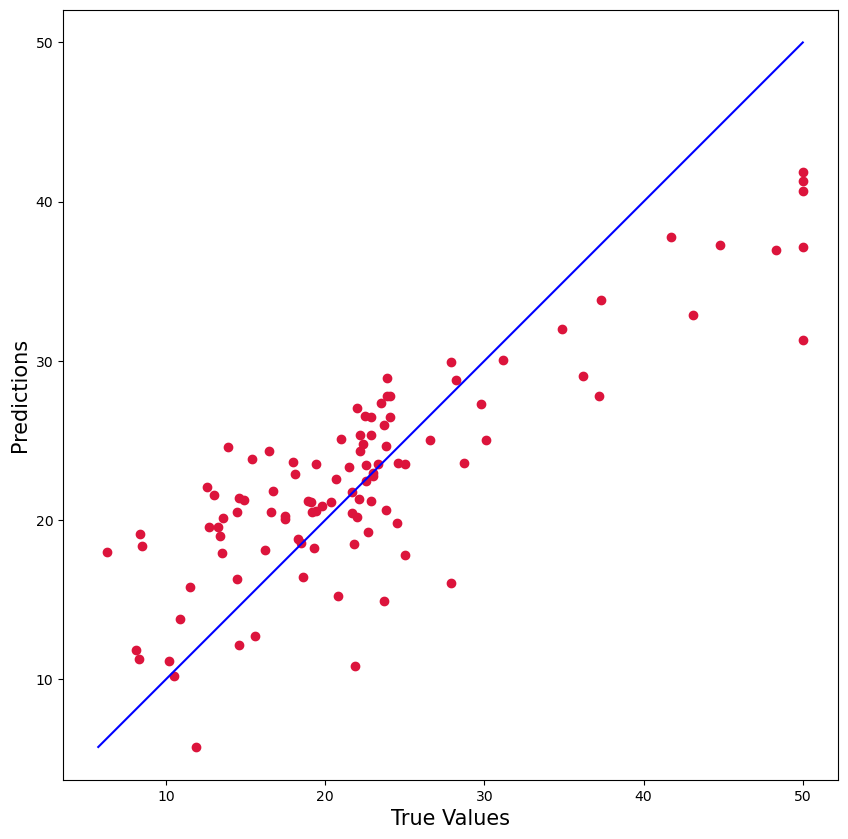

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Split data into train and test with 80/20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

reg = LinearRegression().fit(X_train, y_train)

print(reg.score(X_train,y_train))
print(reg.score(X_test,y_test))
# R2 of 0.53 for training data, 0.67 for testing

y_predict = reg.predict(X_test)

print(mean_squared_error(y_test, y_predict))
# MSE of 32

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_predict, c='crimson')

p1 = max(max(y_predict)[0], y_test.max()[0])
p2 = min(min(y_predict)[0], y_test.min()[0])

plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

0.5108149318288953
0.6785473138649436
29.462581075204668


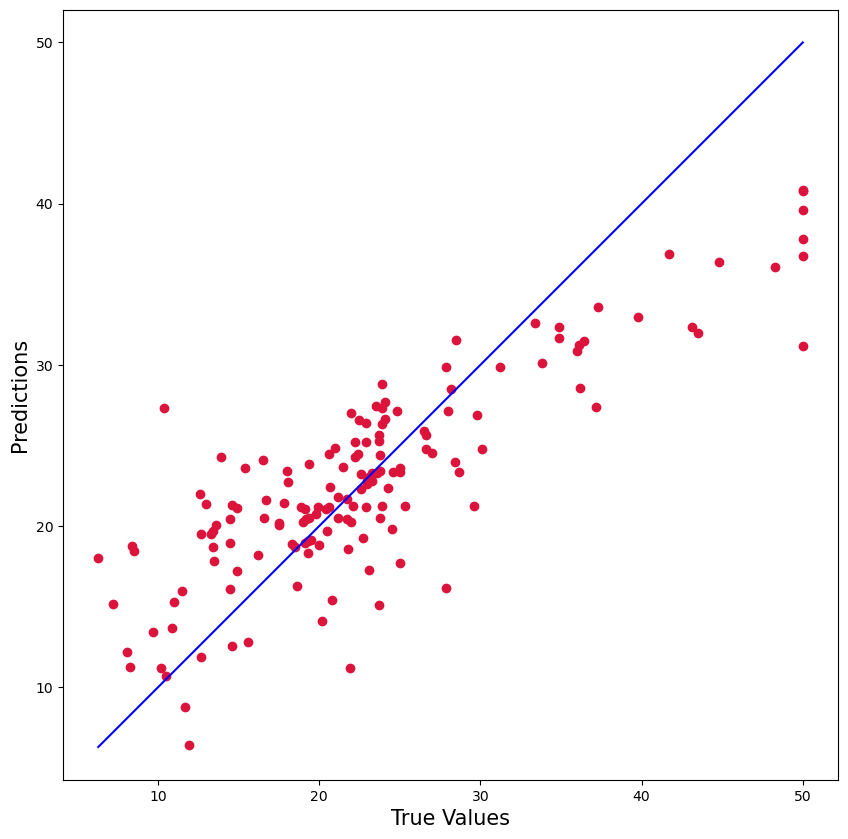

In [12]:
# Split data into train and test with 70/30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

reg = LinearRegression().fit(X_train, y_train)

print(reg.score(X_train,y_train))
print(reg.score(X_test,y_test))
# R2 of 0.51 for training data, 0.68 for testing

y_predict = reg.predict(X_test)

print(mean_squared_error(y_test, y_predict))
# MSE of 29.5

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_predict, c='crimson')

p1 = max(max(y_predict)[0], y_test.max()[0])
p2 = min(min(y_predict)[0], y_test.min()[0])

plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

0.5558648992262509
0.6869187287659181
29.056688804282725


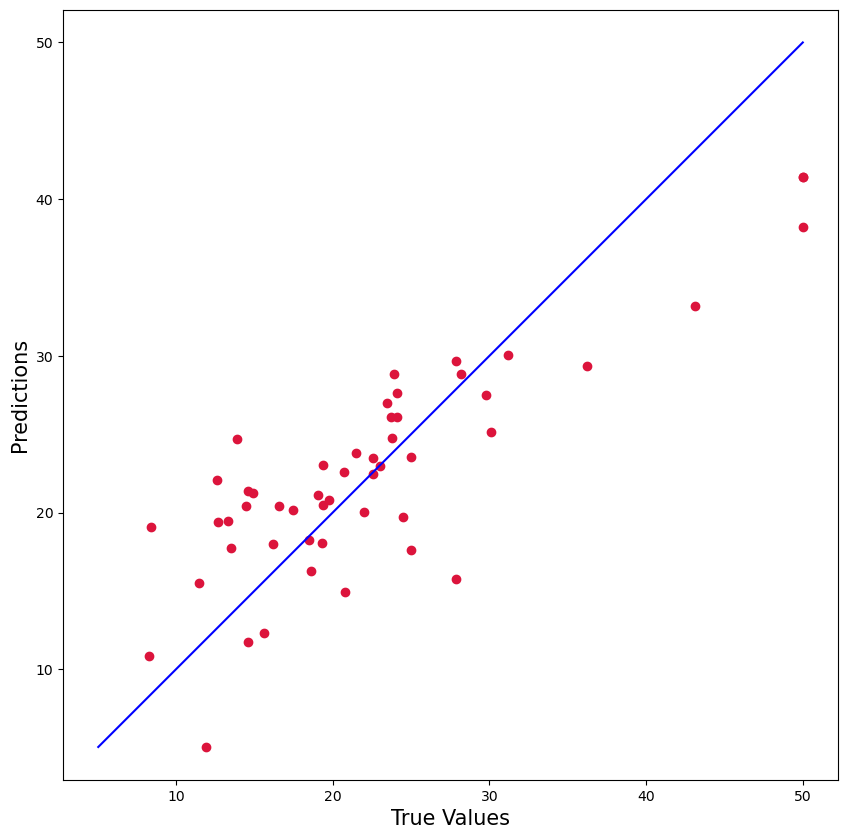

In [13]:
# Split data into train and test with 90/10 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

reg = LinearRegression().fit(X_train, y_train)

print(reg.score(X_train,y_train))
print(reg.score(X_test,y_test))
# R2 of 0.55 for training data, 0.69 for testing

y_predict = reg.predict(X_test)

print(mean_squared_error(y_test, y_predict))
# MSE of 29

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_predict, c='crimson')

p1 = max(max(y_predict)[0], y_test.max()[0])
p2 = min(min(y_predict)[0], y_test.min()[0])

plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [ ]:
# All 3 model seem to be perform better on the non-extreme observations 
# especially against the upper end of the observations.
# Perhaps what the richer neighbourhood values in a house is much different compared to the middle class.

# From the increase in R2 from training to fitting, 
# it is good to know the model is not overfitting and is able to generalise well.
# By just using 4 features, the model can explain close to 50-55% of the actual median value.

# The MSE gets lower with higher train/test ratio. 
# At 90/10 training-testing ratio, the difference in training r2 and testing r2 is still huge.
# Perhaps there are some more room in increasing the ratio.

0.5679531171751411
0.6416313406333622
20.580099556923948


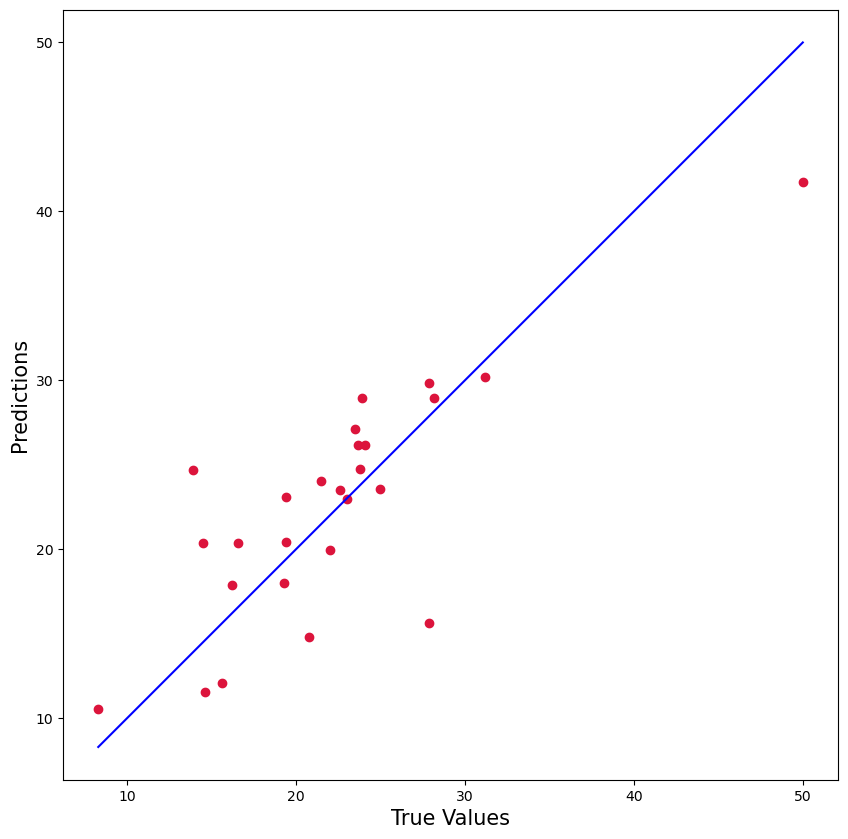

In [15]:
# Split data into train and test with 95/5 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1)

reg = LinearRegression().fit(X_train, y_train)

print(reg.score(X_train,y_train))
print(reg.score(X_test,y_test))
# R2 of 0.56 for training data, 0.64 for testing

y_predict = reg.predict(X_test)

print(mean_squared_error(y_test, y_predict))
# MSE of 20.6

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_predict, c='crimson')

p1 = max(max(y_predict)[0], y_test.max()[0])
p2 = min(min(y_predict)[0], y_test.min()[0])

plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

# MSE decreased to 20.6 while R2 did not deviate much.
# Training R2 is closer to Testing R2, perhaps the model is now less underfitting.
# Does that really mean 95/5 is a more suitable ratio?

# Based on the number of test observations, it still looks sufficient for testing.

### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [16]:
from sklearn.model_selection import KFold

mean_mse_values = []
mean_scores = []

In [17]:
from sklearn import metrics

kf = KFold(n_splits=5, shuffle=True)

mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1


print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

mean_mse_values.append(np.mean(mse_values))
mean_scores.append(np.mean(scores))

~~~~ CROSS VALIDATION each fold ~~~~
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 37.17518428158015
Mean of R2 for all folds: 0.5694346439138183


In [18]:
kf = KFold(n_splits=6, shuffle=True)

mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1


print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

mean_mse_values.append(np.mean(mse_values))
mean_scores.append(np.mean(scores))

~~~~ CROSS VALIDATION each fold ~~~~
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 37.661500598658414
Mean of R2 for all folds: 0.5690920035825451


In [19]:
kf = KFold(n_splits=7, shuffle=True)

mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1


print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

mean_mse_values.append(np.mean(mse_values))
mean_scores.append(np.mean(scores))

~~~~ CROSS VALIDATION each fold ~~~~
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 36.92663445256161
Mean of R2 for all folds: 0.5700308878014048


In [20]:
kf = KFold(n_splits=8, shuffle=True)

mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1

print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

mean_mse_values.append(np.mean(mse_values))
mean_scores.append(np.mean(scores))

~~~~ CROSS VALIDATION each fold ~~~~
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 37.564408111507554
Mean of R2 for all folds: 0.5696173976794405


In [21]:
kf = KFold(n_splits=9, shuffle=True)

mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression(fit_intercept=False).fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1


print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

~~~~ CROSS VALIDATION each fold ~~~~
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 51.42298334754548
Mean of R2 for all folds: 0.4042313680654348


In [22]:
kf = KFold(n_splits=10, shuffle=True)

mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression(fit_intercept=False).fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1


print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

mean_mse_values.append(np.mean(mse_values))
mean_scores.append(np.mean(scores))

~~~~ CROSS VALIDATION each fold ~~~~
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 51.450736903437374
Mean of R2 for all folds: 0.40420677700054075


In [23]:
mean_mse_values

[37.17518428158015,
 37.661500598658414,
 36.92663445256161,
 37.564408111507554,
 51.450736903437374]

In [24]:
mean_scores

[0.5694346439138183,
 0.5690920035825451,
 0.5700308878014048,
 0.5696173976794405,
 0.40420677700054075]

In [25]:
# Not much variation between mse and scores when using different number of folds from 5 to 9.
# Model performance does seem consistent. 

# When k = 10, the performace degraded with mse value went up and (r2) score went down.
# From here it does seem that 8 is the ideal number of neighbours to take.

# KNN Practice

In [26]:
# Read the iris data into a DataFrame
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names)

In [27]:
iris.head()

# Increase the default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

In [28]:
# Create a custom colormap
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

In [29]:
# Map each iris species to a number
# Let's use Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'
iris['species_num'] = iris['species'].map({'Iris-setosa': 0, 'Iris-versicolor':1, 'Iris-virginica':2})

<AxesSubplot: xlabel='petal_length', ylabel='petal_width'>

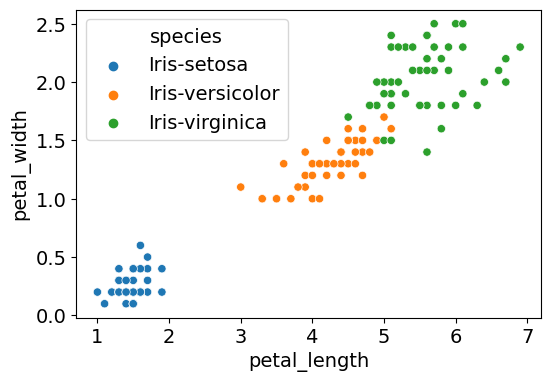

In [30]:
import seaborn as sns

# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES
sns.scatterplot(iris,x='petal_length',y='petal_width',hue='species')

<AxesSubplot: xlabel='sepal_length', ylabel='sepal_width'>

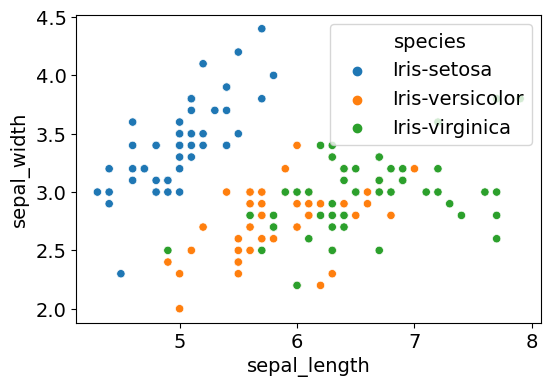

In [31]:
# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES
sns.scatterplot(iris,x='sepal_length',y='sepal_width',hue='species')

## KNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [32]:
X_iris  = iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]

### Create your target vector "y"
This will be the species type.

In [33]:
y_iris = iris['species']

### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, test_size=0.2, shuffle=True)

print(y_test)

95     Iris-versicolor
15         Iris-setosa
0          Iris-setosa
61     Iris-versicolor
45         Iris-setosa
126     Iris-virginica
26         Iris-setosa
17         Iris-setosa
87     Iris-versicolor
138     Iris-virginica
149     Iris-virginica
53     Iris-versicolor
64     Iris-versicolor
104     Iris-virginica
40         Iris-setosa
13         Iris-setosa
117     Iris-virginica
134     Iris-virginica
82     Iris-versicolor
71     Iris-versicolor
109     Iris-virginica
2          Iris-setosa
16         Iris-setosa
11         Iris-setosa
136     Iris-virginica
112     Iris-virginica
22         Iris-setosa
51     Iris-versicolor
9          Iris-setosa
133     Iris-virginica
Name: species, dtype: object


### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [35]:
from sklearn.neighbors import KNeighborsClassifier as knc

kn1 = knc(n_neighbors=1)
kn1.fit(X_train, y_train)

y_predict = kn1.predict(X_test)

print(y_predict)

['Iris-versicolor' 'Iris-setosa' 'Iris-setosa' 'Iris-versicolor'
 'Iris-setosa' 'Iris-virginica' 'Iris-setosa' 'Iris-setosa'
 'Iris-versicolor' 'Iris-virginica' 'Iris-virginica' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-virginica' 'Iris-setosa' 'Iris-setosa'
 'Iris-virginica' 'Iris-virginica' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-virginica' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-virginica' 'Iris-virginica' 'Iris-setosa' 'Iris-versicolor'
 'Iris-setosa' 'Iris-versicolor']


/Users/tanyongjin/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [36]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_predict)

0.9666666666666667

### Create a Model With Five Neighbors. Did it Improve?

In [37]:
kn5 = knc(n_neighbors=5)
kn5.fit(X_train, y_train)

y_predict = kn5.predict(X_test)

print(y_predict)

accuracy_score(y_test, y_predict)

# 93.3% accuracy does seem suspicious, sounds too good to be true

['Iris-versicolor' 'Iris-setosa' 'Iris-setosa' 'Iris-versicolor'
 'Iris-setosa' 'Iris-virginica' 'Iris-setosa' 'Iris-setosa'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-virginica' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-virginica' 'Iris-setosa' 'Iris-setosa'
 'Iris-virginica' 'Iris-virginica' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-virginica' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-virginica' 'Iris-virginica' 'Iris-setosa' 'Iris-versicolor'
 'Iris-setosa' 'Iris-versicolor']


/Users/tanyongjin/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.9333333333333333

### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

In [38]:
acc_list = []

for i in range(1,30):
    kn = knc(n_neighbors=i)
    kn.fit(X_train, y_train)

    y_predict = kn.predict(X_test)

    acc_list.append(accuracy_score(y_test, y_predict))
    
acc_list

# not much difference in accuracy. 
# Ranging from 90% to 96.6%, no significant increase with increasing neighbours.

/Users/tanyongjin/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/tanyongjin/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will n

[0.9666666666666667,
 0.9,
 0.9666666666666667,
 0.9333333333333333,
 0.9333333333333333,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9333333333333333,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9]

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

In [39]:
# knn.predict_proba will provide the prediction percentage for each class (species in this case), per record.
# So rather than taking the class with the highest probability to return as prediction,
# it will provide us an insight on how sure the KNN model is during classification,
# is it 100% sure? or just 60% sure?

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [40]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [41]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                              1221.
Date:                Fri, 20 Jan 2023   Prob (F-statistic):                   1.38e-321
Time:                        11:38:54   Log-Likelihood:                         -1567.5
No. Observations:                 506   AIC:                                      3151.
Df Residuals:                     498   BIC:                                      3185.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             4.9729      0.224     22.195      0.000       4.533       5.413
LSTAT         -0.5606      0.048    -11.795      0.000      -0.654      -0.467
RAD            0.2128      0.070      3.050      0.002       0.076       0.350
TAX           -0.0174      0.004     -4.272      0.000      -0.025      -0.009
NOX            4.3448      3.384      1.284      0.200      -2.304      10.994
INDUS          0.0924      0.067      1.383      0.167      -0.039       0.224
CRIM          -0.0891      0.037     -2.423      0.016      -0.161      -0.017
ZN             0.0288      0.013      2.220      0.027       0.003       0.054
==============================================================================
Omnibus:                      192.139   Durbin-Watson:                   0.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              832.155
Skew:                           1.666   Prob(JB):                    1.99e-181
Kurtosis:                       8.326   Cond. No.                     6.24e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

In [42]:
df.corr()['MEDV']

CRIM      -0.388305
ZN         0.360445
INDUS     -0.483725
CHAS       0.175260
NOX       -0.427321
RM         0.695360
AGE       -0.376955
DIS        0.249929
RAD       -0.381626
TAX       -0.468536
PTRATIO   -0.507787
B          0.333461
LSTAT     -0.737663
MEDV       1.000000
Name: MEDV, dtype: float64

In [43]:
# You can easily swap these out to test multiple versions/different formulas
formulas = {
    # Picking predictors with | corr | > 0.4 with the target variable
    "case1": "MEDV ~ LSTAT + PTRATIO + RM + INDUS + TAX + NOX - 1", # - 1 = remove intercept
    # 0.953
    "case2": "MEDV ~ LSTAT * PTRATIO * RM * INDUS : TAX : NOX - 1",
    # Vectorised Columns
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                              1679.
Date:                Fri, 20 Jan 2023   Prob (F-statistic):                        0.00
Time:                        11:38:54   Log-Likelihood:                         -1561.0
No. Observations:                 506   AIC:                                      3134.
Df Residuals:                     500   BIC:                                      3159.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
LSTAT         -0.4878      0.050     -9.789      0.000      -0.586      -0.390
PTRATIO       -0.5114      0.097     -5.293      0.000      -0.701      -0.322
RM             6.1145      0.286     21.399      0.000       5.553       6.676
INDUS          0.0421      0.061      0.686      0.493      -0.078       0.163
TAX           -0.0055      0.002     -2.497      0.013      -0.010      -0.001
NOX            2.5636      3.268      0.784      0.433      -3.857       8.984
==============================================================================
Omnibus:                      223.505   Durbin-Watson:                   0.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1461.834
Skew:                           1.810   Prob(JB):                         0.00
Kurtosis:                      10.498   Cond. No.                     6.12e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
# Trying out Vectorised Columns with the features found in case 1
model = smf.ols(formula=formulas['case2'], data=df)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              1299.
Date:                Fri, 20 Jan 2023   Prob (F-statistic):                        0.00
Time:                        11:38:54   Log-Likelihood:                         -1395.5
No. Observations:                 506   AIC:                                      2821.
Df Residuals:                     491   BIC:                                      2884.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
LSTAT                             -2.5377      2.703     -0.939      0.348      -7.848       2.772
PTRATIO                           -3.2877      0.293    -11.211      0.000      -3.864      -2.712
LSTAT:PTRATIO                      0.3682      0.153      2.402      0.017       0.067       0.669
RM                                 6.1845      0.890      6.951      0.000       4.436       7.933
LSTAT:RM                           0.3675      0.477      0.771      0.441      -0.569       1.304
PTRATIO:RM                         0.4119      0.076      5.386      0.000       0.262       0.562
LSTAT:PTRATIO:RM                  -0.0599      0.027     -2.193      0.029      -0.113      -0.006
INDUS:TAX:NOX                     -0.0354      0.007     -5.298      0.000      -0.049      -0.022
LSTAT:INDUS:TAX:NOX                0.0017      0.001      3.041      0.002       0.001       0.003
PTRATIO:INDUS:TAX:NOX              0.0023      0.000      6.800      0.000       0.002       0.003
LSTAT:PTRATIO:INDUS:TAX:NOX       -0.0001   2.89e-05     -3.833      0.000      -0.000    -5.4e-05
RM:INDUS:TAX:NOX                   0.0054      0.001      5.322      0.000       0.003       0.007
LSTAT:RM:INDUS:TAX:NOX            -0.0003      0.000     -2.668      0.008      -0.000   -7.06e-05
PTRATIO:RM:INDUS:TAX:NOX          -0.0003   5.21e-05     -6.619      0.000      -0.000      -0.000
LSTAT:PTRATIO:RM:INDUS:TAX:NOX  1.701e-05   5.27e-06      3.227      0.001    6.65e-06    2.74e-05
==============================================================================
Omnibus:                      255.531   Durbin-Watson:                   1.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2690.677
Skew:                           1.948   Prob(JB):                         0.00
Kurtosis:                      13.604   Cond. No.                     1.78e+08
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.78e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

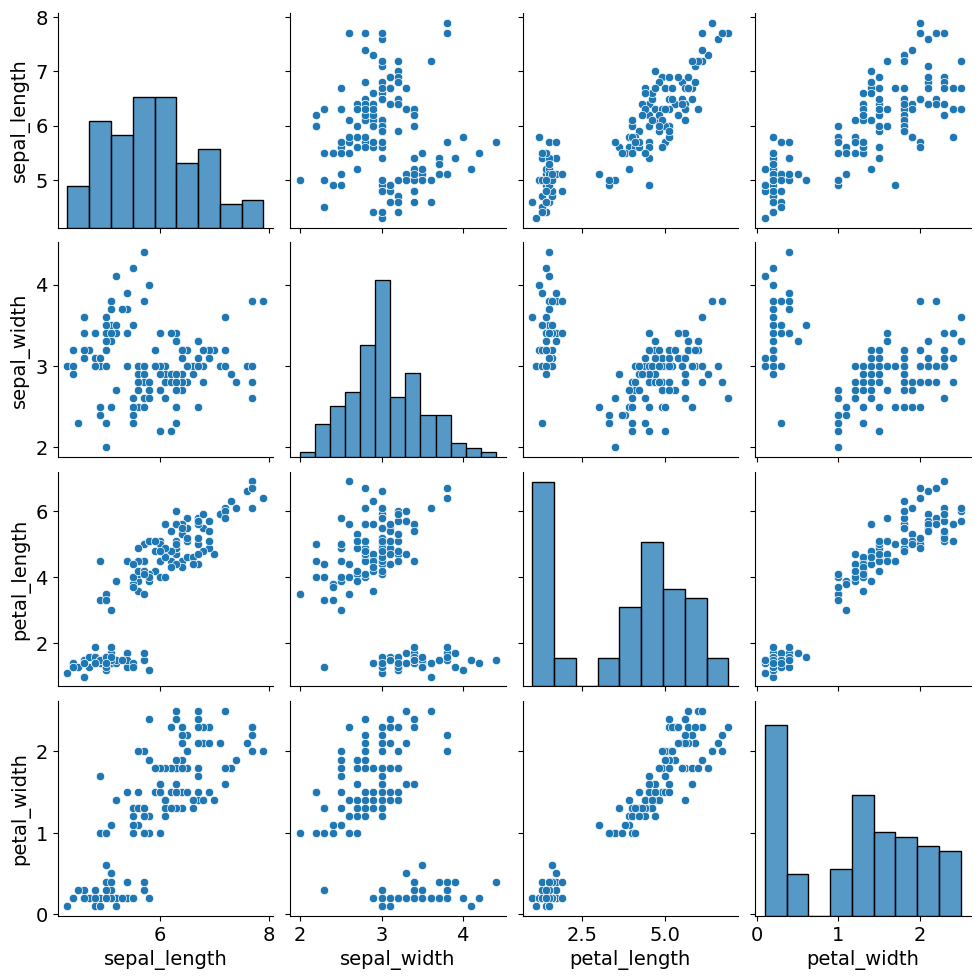

In [45]:
# Check out variable relations
import seaborn as sns

# original
# sns.pairplot(X);

# I reassigned the X from the iris data to X_iris
sns.pairplot(X_iris);

In [46]:
# petal_length / petal_wdith. Looks to be most correlated among all other combinations.
# The correlation coefficient should be close to 1, meaning postively perfectly correlated

In [47]:
# Check out Pearson scores
X_pearson = np.corrcoef(X)

print(X_pearson[2,3])
print(X_pearson[3,2])

0.9999998586860799
0.99999985868608


## Demo: Patsy

In [48]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [49]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ LSTAT + PTRATIO + RM + INDUS + TAX + NOX - 1", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.65)


In [50]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))

R^2 Score: 0.638775996700748
